# Image Recognition

The activity performed in this report is related to image recognition in which we are going to
classify the images of the game (Rock, Paper, Scissors). 
Our goal is to classify the images into
three classes Rock (closed fist), Paper (a flat hand) and Scissors (the index and middle fingers
extended to form a “V”).

In [61]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

import numpy as np
print(np.__version__)

import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

2.8.2
1.21.6
3.2.2


Check whether a GPU is present:

In [62]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Seed is being set to ensure the maximum reproducibility:

In [63]:
np.random.seed(0)
tf.random.set_seed(0)

## Dataset

We imported the `rock_paper_scissors` dataset from tensorflow. Our dataset consists of 2,892 examples which contains 372 test samples and 2,520 training samples.All the images have the resolution of 300
× 300 pixels in RGB color space (3 channels).

In [64]:
datasets, info = tfds.load(name='rock_paper_scissors', with_info=True, as_supervised=True, split=['train','test'])

In [65]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

These are some of the examples present in our test dataset.

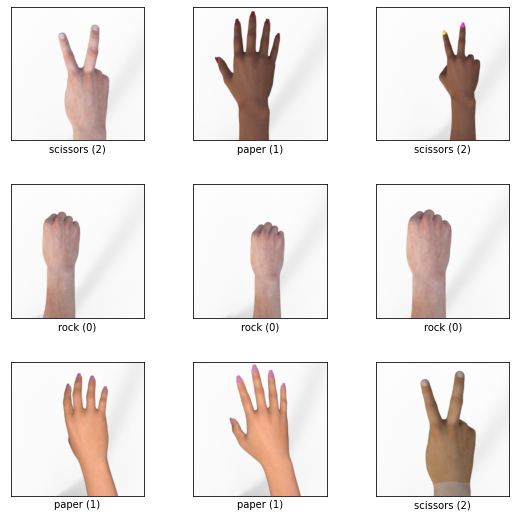

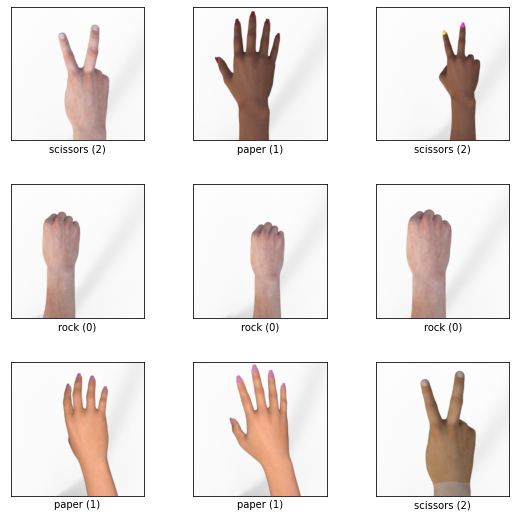

In [66]:
tfds.show_examples(
    datasets[1],
    info,
)

We merged the test and train data together and shuffled it. After shuffling, we took first __300__ samples for validation, then next __300__ samples for testing and rest of the data is used for training.

In [67]:
dataset=datasets[0].concatenate(datasets[1])
dataset=dataset.shuffle(3000)

In [68]:
val_data=dataset.take(300)
temp_data=dataset.skip(300)
test_data=temp_data.take(300)
train_data=temp_data.skip(300)

In [69]:
num_classes = info.features['label'].num_classes
num_train = len(list(train_data))
num_test = len(list(val_data))
num_val = len(list(test_data))

print("Number of classes:", num_classes)
print("Number of training samples:", num_train)
print("Number of validation samples:",  num_test)
print("Number of test samples:", num_val)

Number of classes: 3
Number of training samples: 2292
Number of validation samples: 300
Number of test samples: 300


## Data Preprocessing

### Format Data
We resized the image to 224x224 and rescaled the image from [-1,1]

In [70]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

### Data Augmentation
We used data augmentation techniques (i.e flipping of the image, create random brightness and contrast) to create variations in our training dataset. 

In [71]:
def augment_data(image, label):
  image, label = format_image(image, label)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, 0.05)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  return image, label

Inspect the actual range of the pixels of one of the training data image

In [72]:
image, label = next(iter(train_data))
scaled_img, _ = format_image(image,label)
print("Min and max pixel values:", scaled_img.numpy().min(), scaled_img.numpy().max())

Min and max pixel values: -0.8721131 0.99795735


Apply augmentation on training images and scale all the images. In the end, make the batches of the images

In [73]:
SHUFFLE_BUFFER_SIZE = 2300
BATCH_SIZE = 64

train_scaled_batches = train_data.map(augment_data).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_scaled_batches =  test_data.map(format_image).batch(BATCH_SIZE)
val_scaled_batches =  val_data.map(format_image).batch(BATCH_SIZE)

Inspect the first batch (of 64 images) in training data

In [74]:
for image_batch, _ in train_scaled_batches.take(1):
  print(image_batch.shape)

(64, 224, 224, 3)


##Base Model
We used __mobilenetv2__ as our base model.

The model is loaded with pretrained weights on __imagenet__. By specifying the __include_top=False__ argument, we loaded a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [75]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


This feature extractor layer converts `224x224x3` to `7x7x1280` block of features. See what it does to the example batch of images

In [76]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


Here we froze the convolution base by setting __base_model.trainable = False__  that will prevent the weights in a given model from being updated during training.

In [77]:
base_model.trainable = False
base_model._name = "mobilenetv2"

In [78]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                       

We stacked the feature extractor layer with average pooling (used for flattening of the layer) and dense layer (contains softmax since we have more than two classes).

The 2.2M parameters in MobileNet are frozen, but there are 3.8K trainable parameters in the Dense layer.

In [79]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2 (Functional)    (None, 7, 7, 1280)        2257984   
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


##Compile the model
We have to compile the model before training it. We are using Adam optimizer with categorical cross entropy.  

In [80]:
lr = 0.001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Validation accuracy before the training is very low 

In [81]:
loss0, accuracy0 = model.evaluate(val_scaled_batches)

5/5 [==============================] - 7s 74ms/step - loss: 1.3900 - accuracy: 0.3167


In [82]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.39
initial accuracy: 0.32


## Train the model

After training for 8 epochs, the validation accuracy of the model reached to ~99%. 


In [83]:
EPOCHS = 8

In [84]:
history = model.fit(train_scaled_batches, epochs=EPOCHS, validation_data=val_scaled_batches)

Epoch 1/8
36/36 [==============================] - 21s 233ms/step - loss: 0.7644 - accuracy: 0.6907 - val_loss: 0.4243 - val_accuracy: 0.9167
Epoch 2/8
36/36 [==============================] - 19s 232ms/step - loss: 0.2980 - accuracy: 0.9337 - val_loss: 0.2708 - val_accuracy: 0.9633
Epoch 3/8
36/36 [==============================] - 19s 233ms/step - loss: 0.2060 - accuracy: 0.9490 - val_loss: 0.1955 - val_accuracy: 0.9567
Epoch 4/8
36/36 [==============================] - 27s 480ms/step - loss: 0.1519 - accuracy: 0.9664 - val_loss: 0.1543 - val_accuracy: 0.9833
Epoch 5/8
36/36 [==============================] - 20s 234ms/step - loss: 0.1314 - accuracy: 0.9686 - val_loss: 0.1414 - val_accuracy: 0.9800
Epoch 6/8
36/36 [==============================] - 24s 379ms/step - loss: 0.1160 - accuracy: 0.9743 - val_loss: 0.1032 - val_accuracy: 0.9867
Epoch 7/8
36/36 [==============================] - 19s 234ms/step - loss: 0.0975 - accuracy: 0.9760 - val_loss: 0.0822 - val_accuracy: 0.9900
Epoch 

These are the learning curves of the training and validation accuracy/loss.

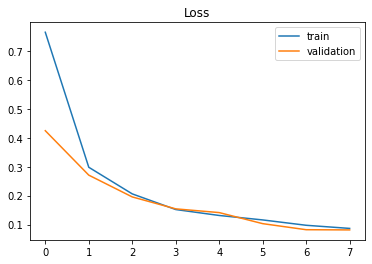

In [86]:
epochs_range = range(EPOCHS)
plt.title("Loss")
plt.plot(epochs_range,history.history['loss'], label = 'train')
plt.plot(epochs_range,history.history['val_loss'], label = 'validation')
plt.legend(loc='upper right')
plt.show()

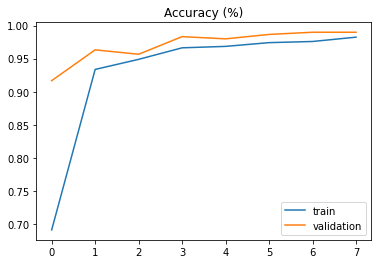

In [87]:
plt.title("Accuracy (%)")
plt.plot(epochs_range,history.history['accuracy'], label = 'train')
plt.plot(epochs_range,history.history['val_accuracy'], label = 'validation')
plt.legend(loc='lower right')
plt.show()

Saved the model in the local workspace.

In [88]:
model.save('./models')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [89]:
ls models

assets/  keras_metadata.pb  saved_model.pb  variables/


In [90]:
loaded_model = tf.keras.models.load_model('models')

#Evaluation 
We took some of the images from our test data and evaluated those images with our model. At the end, we printed there original label along with there predicted label.

[[2.5216033e-04 9.9008614e-01 9.6616941e-03]]


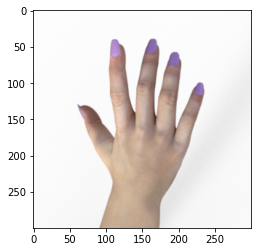

Actual Label: paper
Predicted Label: paper
[[0.00260872 0.9747116  0.02267964]]


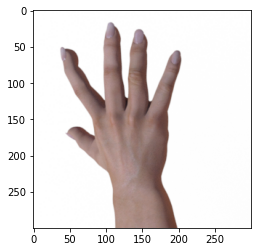

Actual Label: paper
Predicted Label: paper
[[0.45539907 0.5432926  0.00130839]]


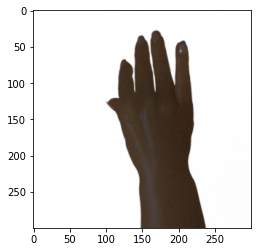

Actual Label: paper
Predicted Label: paper
[[0.00170147 0.96764386 0.03065477]]


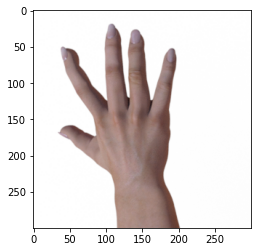

Actual Label: paper
Predicted Label: paper
[[0.00540352 0.981513   0.01308339]]


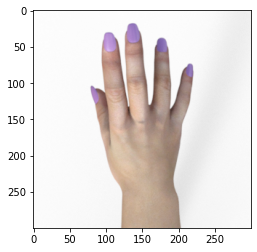

Actual Label: paper
Predicted Label: paper
[[0.04840901 0.0717954  0.87979555]]


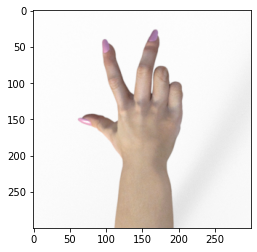

Actual Label: scissors
Predicted Label: scissors
[[0.02019663 0.95767885 0.02212447]]


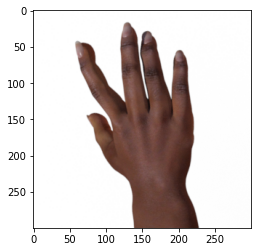

Actual Label: paper
Predicted Label: paper
[[9.9977630e-01 4.2786145e-05 1.8087628e-04]]


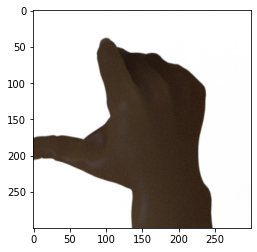

Actual Label: rock
Predicted Label: rock
[[7.5699494e-04 3.0088271e-03 9.9623424e-01]]


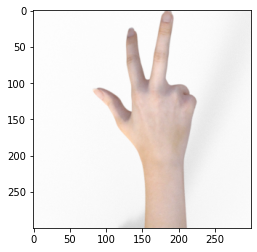

Actual Label: scissors
Predicted Label: scissors
[[0.00861032 0.01177383 0.9796158 ]]


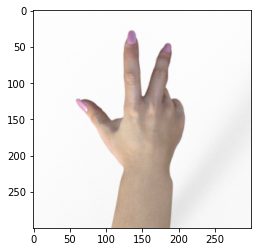

Actual Label: scissors
Predicted Label: scissors


In [91]:
for test_sample in test_data.take(10):  
  image, label = test_sample[0], test_sample[1]
  
  image_scaled, label_arr= format_image(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   
  pred=loaded_model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])

#Resources 
These are the resources of the project

[https://github.com/srivatsan88/YouTubeLI/blob/master/Rock_Paper_Scissor_Transfer_Learning.ipynb](https://github.com/srivatsan88/YouTubeLI/blob/master/Rock_Paper_Scissor_Transfer_Learning.ipynb)
[https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb)